#### Reading instance and defining model

In [115]:
# Reading instance

from instanceReaderRealInstances import Instance
import numpy as np

instanceName = "INST_REL_JO_NA_9.txt"

MV = 8

artificial_depot = False

inst = Instance(instanceName,
                avgSpeed=50,
                model = 'SMDHPDPTW',
                artificial_depot=artificial_depot)

In [116]:
# Instance data

df_instance = inst.instance_data

df_instance = df_instance.iloc[0:13].copy()

In [117]:
import pandas as pd

# Importing pyomo modules

import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory

# Creating model
model = pyo.ConcreteModel()

## Defining sets and notation

## $ S_{0} = \{1, ... , s\} $
## $ P = \{s + 1, ... , 2s\} $
## $ D = \{2s + 1, ... , 2s + n\} $

#### Vehicles set

## $ \newline K = \{1, ..., m\} $

#### Visits set

## $ \newline V = \{1, ..., MV\} $


In [118]:
# Sets

model.setN = pyo.Set(initialize=range(len(df_instance)))
model.setP = pyo.Set(initialize=df_instance[df_instance['type'] == 'Pickup'].index)
model.setD = pyo.Set(initialize=df_instance[df_instance['type'] == 'Delivery'].index)

# Additional sets

# Depot nodes
model.setS_0 = pyo.Set(initialize=df_instance[df_instance['type'] == 'Depot'].index)

# Set of vehicles
model.setK = pyo.Set(initialize=range(len(inst.K)))

# Set of visits
model.setV = pyo.Set(initialize=range(MV))

#### Defining variables

### $x_{ijkv} = \text{1 if vehicle $k$ travels from $i$ to $j$ in its $v$ visit and 0 otherwise;} $

### $y_{ikv} = \text{amount of load in vehicle $k$ after visiting node $i$ in its $v$ visit;} $

### $z_{ikv} = \text{amount of load supplied/delivered by vehicle $k$ to node $i$ in its $v$ visit;} $

In [119]:
# Variables

model.x = pyo.Var(model.setN, model.setN, model.setK, model.setV, within = pyo.Binary)

model.y = pyo.Var(model.setN, model.setK, model.setV, within = NonNegativeReals)

model.z = pyo.Var(model.setN, model.setK, model.setV, within = NonNegativeReals)

#### Defining constraints

#### Objective function

## $ (1) $

## $$ max \displaystyle \sum_{i \in D}\displaystyle \sum_{k \in K}\displaystyle \sum_{v \in V}z_{ikv} - \gamma\displaystyle \sum_{i,j \in N}\displaystyle \sum_{k \in K}\displaystyle \sum_{v \in V}c_{ijk}x_{ijkv} $$

In [120]:
# (1) - Objective function

# costs FO
model.exprobj = sum(sum(sum(model.z[i,k,v] for i in model.setD) for k in model.setK) for v in model.setV) - 0.01*(sum(sum(sum(sum(inst.c[i][j][k]*model.x[i,j,k,v] for i in model.setN) for j in model.setN) for k in model.setK) for v in model.setV))

model.obj = pyo.Objective(expr= model.exprobj, sense = pyo.maximize)

## $ (2) $

## $$ \displaystyle \sum_{i \in N}x_{ihk(v-1)} -  \displaystyle \sum_{j \in N}x_{hjkv} + \sum_{i,j \in N}x_{ijkv} \leq 1 , \quad \forall h \in P \cup D, k \in K, v \in V $$

In [121]:
# (2) Flow conservation - if vehicle k goes from i to h, it has to go from h to j on the next visit

model.R2 = pyo.ConstraintList()

for h in (model.setP | model.setD):
    
    for k in model.setK:
        
        for v in range(1,len(model.setV)):

            model.R2.add(expr = sum(model.x[i,h,k,v-1] for i in (model.setN)) - sum(model.x[h,j,k,v] for j in (model.setN)) + sum(sum(model.x[i,j,k,v] for i in model.setN) for j in model.setN) <= 1)

## $ (3) $



## $$ \displaystyle \sum_{i \in N}\sum_{j \in N}x_{ijkv} \leq 1, \hspace{15pt} \forall k \in K, v \in V $$

In [122]:
# (3) There can be only one visit per visit index per vehicle

model.R3 = pyo.ConstraintList()
        
for k in model.setK:
    
    for v in model.setV:

        model.R3.add(expr = sum(sum(model.x[i, j, k, v] for i in model.setN) for j in model.setN) <= 1)

## $ (4) $



## $$ \displaystyle \sum_{i,j \in N}x_{ijk(v - 1)} \geq \displaystyle \sum_{i,j \in N}x_{ijkv}, \quad \forall k \in K, v \in V $$

In [123]:
# (4) Symmetry constraint

model.R4 = pyo.ConstraintList()

for k in model.setK:

    for v in range(1,len(model.setV)):

        model.R4.add(expr = sum(sum(model.x[i,j,k,v-1] for i in model.setN) for j in model.setN) >= sum(sum(model.x[i,j,k,v] for i in model.setN) for j in model.setN))

## $ (5) $



## $$ \displaystyle \sum_{i,j \in N}\sum_{v \in V}t_{ijk}x_{ijkv} \leq T, \quad \forall k \in K $$

In [124]:
# (5) Planning horizon definition

model.R5 = pyo.ConstraintList()

PH = 16

for k in model.setK:
    
    model.R5.add(expr = 
                  sum(sum(sum(inst.t[i][j][k]*model.x[i,j,k,v] for i in model.setN) for j in model.setN) for v in model.setV) <= PH
                 )

## $ (7) $

## $$ \displaystyle \sum_{j \in N}\sum_{k \in K}x_{ijk0} \leq K_{i}, \hspace{15pt} \forall i \in S_{0} $$

In [125]:
# (6) - Number of vehicles that depart from depot must be equal to number of vehicles available at depot

# K_{i} - Number of vehicles that start their route at depot i in S_0

K = [len(location) for location in inst.vehicle_locations]

model.R6 = pyo.ConstraintList()

for i in (model.setS_0):

    model.R6.add(expr = sum(sum(model.x[i,j,k,0] for j in model.setN) for k in model.setK) == K[i])

## $ (7) $



## $$ y_{jkv} \geq y_{ik(v-1)} + z_{jkv} - M(1-x_{ijkv}), \newline\forall i \in N, j \in P, k \in K, v \in V $$

In [126]:
# (7) - Load constraints - 1 (pickup)

M = 10000

model.R7 = pyo.ConstraintList()

for i in model.setN:
    
    for j in model.setP:
        
        for k in model.setK:
    
            for v in range(1, len(model.setV)):
        
                model.R7.add(expr = model.y[j,k,v] >= model.y[i,k,v-1] + model.z[j,k,v] - M*(1 - model.x[i,j,k,v]))
            
                model.R7.add(expr = model.y[j,k,v] <= model.y[i,k,v-1] + model.z[j,k,v] + M*(1 - model.x[i,j,k,v]))
                
# (7) - Load constraints - first pickup

for i in model.setN:
        
    for k in model.setK:

            model.R7.add(expr = model.y[i,k,0] >= model.z[i,k,0])

            model.R7.add(expr = model.y[i,k,0] <= model.z[i,k,0])

## $ (8) $



## $$ y_{jkv} \geq y_{ik(v-1)} - z_{jkv} - M(1-x_{ijkv}), \newline\forall i \in N, j \in D, k \in K, v \in V $$

In [127]:
# (8)  - Load constraints - 2 (delivery)

model.R8 = pyo.ConstraintList()

for i in model.setN:
    
    for j in model.setD:
        
        for k in model.setK:
    
            for v in range(1, len(model.setV)):
            
                model.R8.add(expr = model.y[j,k,v] >= model.y[i,k,v-1] - model.z[j,k,v] - M*(1 - model.x[i,j,k,v]))
                
                model.R8.add(expr = model.y[j,k,v] <= model.y[i,k,v-1] - model.z[j,k,v] + M*(1 - model.x[i,j,k,v]))
                
                
M = 10000

model.RL = pyo.ConstraintList()

for i in model.setD:
    
    for j in model.setP:
        
        for k in model.setK:
            
            for v in model.setV:
                
                model.RL.add(expr = model.y[i,k,v] <= -M*(model.x[i,j,k,v] - 1))

## $ (9) $



## $$ \displaystyle y_{ikv} \leq Q_{k}, \hspace{15pt} \forall i \in N , k \in K, v \in V$$

In [128]:
# (9) - Load constraints upper bound

model.R9 = pyo.ConstraintList()

for i in model.setN:

        for k in model.setK:

            for v in model.setV:

                model.R9.add(expr = model.y[i,k,v] <= inst.K[k])

## $ (10) $


## $$ \displaystyle \sum_{k \in K}\sum_{v \in V} z_{ikv} \leq d_{i}, \hspace{15pt} \forall i \in P \cup D $$

In [129]:
# (10)  - Total amount picked up/delivered to each node can't be above node supply/demand

model.R10 = pyo.ConstraintList()

for i in (model.setP | model.setD):

    model.R10.add(expr = sum(sum(model.z[i, k, v] for k in model.setK) for v in model.setV) <= abs(inst.d[i]))

## $ (11) $


## $$  z_{ikv} \leq d_{i}\displaystyle \sum_{j \in N}x_{jikv}, \hspace{15pt} \forall i \in N, k \in K, v \in V $$

In [130]:
# (11) - Amount delivered to a node in a single visit can't exceed node demand

model.R11 = pyo.ConstraintList()

for i in model.setN:
    
    for k in model.setK:
        
        for v in model.setV:

            model.R11.add(expr = model.z[i, k, v] <= abs(inst.d[i])*sum(model.x[j,i,k,v] for j in model.setN))

## $ (12) $


## $$  \displaystyle \sum_{i \in P}\sum_{v \in V} z_{ikv} =\displaystyle \sum_{i \in D}\sum_{v \in V}z_{ikv}, \forall k \in K$$

In [131]:
# (17) - Total delivered amount by a vehicle needs to be equal to total picked up demand

model.R12 = pyo.ConstraintList()

for k in model.setK:
    
    model.R12.add(expr = sum(sum(model.z[i, k, v] for i in model.setP) for v in model.setV) == sum(sum(model.z[i, k, v] for i in model.setD) for v in model.setV))


#### Valid inequalities

In [132]:
# No "node to initial depot" arcs or "final depot to nodes" arcs

model.VI1 = pyo.ConstraintList()

for i in model.setN:
    
    for k in model.setK:
        
        for v in model.setV:

            for h in model.setS_0:

                model.VI1.add(expr= model.x[i, h, k, v] == 0)
            
# No initial depot to delivery nodes

model.VI2 = pyo.ConstraintList()

for i in model.setS_0:
    
    for j in model.setD:
    
        for k in model.setK:
            
            for v in model.setV:
        
                model.VI2.add(expr = model.x[i,j,k,v] == 0)
          
        
    # No arcs between pickup nodes (is this necessary?)

model.VI3 = pyo.ConstraintList()

for i in model.setP:
    
    for j in model.setP:
        
        for k in model.setK:

            for v in model.setV:

                model.VI3.add(expr = model.x[i, j, k, v] == 0)


    # Trying to forbid "fake visits"
    
model.VI4 = pyo.ConstraintList()

for i in model.setN:
    
    for k in model.setK:
        
        for v in model.setV:
            
            model.VI4.add(expr= model.x[i, i, k, v] == 0)
            
    
    # Time windows inequalities    

model.VI5 = pyo.ConstraintList()

for i in model.setN:
    
    for j in model.setN:
        
        for k in model.setK:
            
            for v in model.setV:
        
                if inst.t[i][j][k] > PH:

                    model.VI5.add(expr= model.x[i, j, k, v] == 0)
                    
    # No nodes from initial depots in visits higher than 0

model.VI6 = pyo.ConstraintList()

for i in model.setS_0:
    
    for j in model.setN:
        
        for k in model.setK:

            for v in range(1, len(model.setV)):

                model.VI6.add(expr = model.x[i, j, k, v] == 0)

In [133]:
# Equity constraint

model.EQT = pyo.ConstraintList()

# Sum of all delivery needs
D = sum([abs(el) for el in inst.d if el < 0])

epsilon = 0.15

for i in model.setD:
    
    # Z = sum(sum(sum(model.z[i,k,v] for i in model.setD) for k in model.setK) for v in model.setV)
    
    # z_i = sum(sum(model.z[i,k,v] for k in model.setK) for v in model.setV)
    
    
    model.EQT.add(expr = 
                    
                    D*(sum(sum(model.z[i,k,v] for k in model.setK) for v in model.setV)) - np.abs(inst.d[i])*(sum(sum(sum(model.z[i,k,v] for i in model.setD) for k in model.setK) for v in model.setV)) <= epsilon*D*(sum(sum(sum(model.z[i,k,v] for i in model.setD) for k in model.setK) for v in model.setV))
                    
                   )
    
    
    model.EQT.add(expr = 
                    

                np.abs(inst.d[i])*(sum(sum(sum(model.z[i,k,v] for i in model.setD) for k in model.setK) for v in model.setV)) - D*(sum(sum(model.z[i,k,v] for k in model.setK) for v in model.setV)) <= epsilon*D*(sum(sum(sum(model.z[i,k,v] for i in model.setD) for k in model.setK) for v in model.setV))

                   )


#### Solving model

In [134]:
# Solver

TimeLimit = 3600

opt = pyo.SolverFactory('cplex', executable='C:/Program Files/IBM/ILOG/CPLEX_Studio201/cplex/bin/x64_win64/cplex')
opt.options['TimeLimit'] = TimeLimit

opt.options['mipgap'] = 0.01

results = opt.solve(model, tee=True)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\User\AppData\Local\Temp\tmp0wi0gct7.cplex.log' open.
CPLEX> New value for mixed integer optimality gap tolerance: 0.01
CPLEX> New value for time limit in seconds: 3600
CPLEX> Problem 'C:\Users\User\AppData\Local\Temp\tmp6aohkgzr.pyomo.lp' read.
Read time = 0.08 sec. (1.70 ticks)
CPLEX> Problem name         : C:\Users\User\AppData\Local\Temp\tmp6aohkgzr.pyomo.lp
Objective sense      : Maximize
Variables            :    4681  [Nneg: 625,  Binary: 4056]
Objective nonzeros   :    3768
Linear constraints   :    9464  [Less: 7448,  Equal: 2016]
  Nonzeros           :   89470
  RHS nonzeros 

   2632     0     9103.5207   152     5738.6907      Cuts: 60   123836   58.63%
   2632     0     9103.0845   145     5738.6907      Cuts: 79   124189   58.63%
   2632     2     9103.0845   145     5738.6907     9103.0845   124189   58.63%
   2635     4     9103.0239   136     5738.6907     9103.0210   124854   58.63%
   2643     4     9093.0017   101     5738.6907     9102.8373   126029   58.62%
   2665    15     9090.8205    81     5738.6907     9102.8373   128483   58.62%
Elapsed time = 134.53 sec. (31548.46 ticks, tree = 0.08 MB, solutions = 21)
   2686    51     9081.0734    93     5738.6907     9102.8373   135661   58.62%
   2727    90     9094.8624   110     5738.6907     9102.8373   141488   58.62%
   2754    97     9084.1183    88     5738.6907     9102.8373   143064   58.62%
   2786   141     9086.3745    82     5738.6907     9102.8373   151276   58.62%
   2855   173     9079.3081    80     5738.6907     9102.8373   154608   58.62%
   2943   253     9084.2112    67     5738.6

* 26715+23231                         6490.5089     9101.1045            40.22%
* 26761+23231                         6493.7527     9101.1045            40.15%
* 26770+23231                         6494.7823     9101.1045            40.13%
* 26772+23394                         6502.0358     9101.1045            39.97%
* 26777+23231                         7191.0089     9101.1045            26.56%
* 26837+23231                         7231.0652     9101.1045            25.86%
* 26844+23231                         7290.7421     9101.1045            24.83%
  27159 23922     9084.8240    84     7290.7421     9101.1045   998507   24.83%
  27790 23681     9055.5773    98     7290.7421     9101.1045  1015263   24.83%
* 27848+23394                         7296.3982     9101.1045            24.73%
* 27887+23394                         7522.6134     9101.1045            20.98%
* 28048+23394                         7672.6134     9101.1045            18.62%
  28600 24337     9088.4591    92     76

  97883   133     9101.6992   163     7672.6134     9099.6651  3744729   18.60%
  97949   208     9078.1443    89     7672.6134     9099.6651  3753581   18.60%
  98070   267     9074.3546    63     7672.6134     9099.6651  3759031   18.60%
  98218   395     9062.8279    50     7672.6134     9099.6651  3771793   18.60%
  98395   556     9085.2822    90     7672.6134     9099.6651  3791576   18.60%
  98580   725     9056.1558    83     7672.6134     9099.6651  3809101   18.60%
  98809   846     9073.9560    96     7672.6134     9099.6651  3827417   18.60%
  99113  1194     9088.0075   128     7672.6134     9099.6651  3849672   18.60%
Elapsed time = 2102.91 sec. (433379.13 ticks, tree = 50.96 MB, solutions = 52)
  99440  1521     9074.3852    90     7672.6134     9099.6651  3867208   18.60%
  99836  1780     9089.1352    91     7672.6134     9099.6651  3878762   18.60%
 100175  2105     9063.2959    91     7672.6134     9099.6651  3896864   18.60%
 100706  2473     9067.3201    63     767

 146080 45288     9045.2733    56     7673.5993     9098.7824  6170826   18.57%
*146114+45028                         7677.9779     9098.7824            18.50%
 146564 45624     9022.5941    60     7677.9779     9098.7540  6188745   18.50%
*146584+45497                         7728.6134     9098.7540            17.73%
 147079 45665     7869.3459    38     7728.6134     9098.7334  6213209   17.73%
*147086+45800                         7729.9111     9098.7334            17.71%
 147426 46258     8116.3395    94     7729.9111     9098.7285  6254714   17.71%
*147544+46276                         7731.0564     9098.7185            17.69%
*147735+46370                         7731.4227     9098.7185            17.68%
 147918 46545     9084.5397   118     7731.4227     9098.7185  6272743   17.68%
*148391+47067                         7734.7056     9098.7185            17.63%
 148403 46783     8048.2778    81     7734.7056     9098.7185  6275605   17.63%
 148796 47405     8695.7651    60     77

In [135]:
for k in model.setK:
    
    print('\n\n')
    
    total_time = 0
    
    for v in model.setV:

        for i in model.setN:

            for j in model.setN:

                if (pyo.value(model.x[i,j,k,v]))>0.01:

                    print(f'x[{i}, {j}, {k}, {v}] == {pyo.value(model.x[i,j,k,v])}')
                    
                    total_time += inst.t[i][j][k]
                    
    print(total_time)




x[1, 3, 0, 0] == 1.0
x[3, 12, 0, 1] == 1.0
x[12, 3, 0, 2] == 1.0
x[3, 4, 0, 3] == 1.0
x[4, 2, 0, 4] == 1.0
x[2, 4, 0, 5] == 1.0
x[4, 2, 0, 6] == 1.0
x[2, 4, 0, 7] == 1.0
11.868662



x[0, 2, 1, 0] == 1.0
x[2, 6, 1, 1] == 1.0
x[6, 2, 1, 2] == 1.0
x[2, 6, 1, 3] == 1.0
x[6, 2, 1, 4] == 1.0
x[2, 7, 1, 5] == 1.0
x[7, 2, 1, 6] == 1.0
x[2, 6, 1, 7] == 1.0
11.267826000000001



x[1, 3, 2, 0] == 1.0
x[3, 11, 2, 1] == 1.0
x[11, 2, 2, 2] == 1.0
x[2, 6, 2, 3] == 1.0
x[6, 2, 2, 4] == 1.0
x[2, 7, 2, 5] == 1.0
x[7, 2, 2, 6] == 1.0
x[2, 4, 2, 7] == 1.0
15.688796000000002


In [144]:
for k in model.setK:
    
    print('\n\n')
    
    for v in model.setV:

        for i in model.setN:

            for j in model.setN:

                if ((pyo.value(model.x[i,j,k,v]))>0.01):

                    print(f'z[{j}, {k}, {v}] == {pyo.value(model.z[j,k,v])}')




z[3, 0, 0] == 550.0000000000002
z[12, 0, 1] == 550.0000000000001
z[3, 0, 2] == 550.0000000000009
z[4, 0, 3] == 550.0
z[2, 0, 4] == 550.0000000000001
z[4, 0, 5] == 550.0
z[2, 0, 6] == 549.9999999999989
z[4, 0, 7] == 550.0



z[2, 1, 0] == 700.0000000000002
z[6, 1, 1] == 700.0
z[2, 1, 2] == 700.0
z[6, 1, 3] == 699.9999999999999
z[2, 1, 4] == 699.9999999999999
z[7, 1, 5] == 699.9999999999999
z[2, 1, 6] == 700.0
z[6, 1, 7] == 700.0



z[3, 2, 0] == 700.0000000000009
z[11, 2, 1] == 700.0000000000001
z[2, 2, 2] == 700.0
z[6, 2, 3] == 700.0000000000009
z[2, 2, 4] == 700.0
z[7, 2, 5] == 699.9999999999999
z[2, 2, 6] == 700.0
z[4, 2, 7] == 699.9999999999999


In [145]:
for k in model.setK:
    
    for v in model.setV:

        for i in model.setN:

            for j in model.setN:

                if ((pyo.value(model.x[i,j,k,v]))>0.01):

                    print(f'y[{j}, {k}, {v}] == {pyo.value(model.y[j,k,v])}')

y[3, 0, 0] == 550.0000000000002
y[12, 0, 1] == 0.0
y[3, 0, 2] == 550.0
y[4, 0, 3] == 0.0
y[2, 0, 4] == 550.0
y[4, 0, 5] == 0.0
y[2, 0, 6] == 550.0
y[4, 0, 7] == 0.0
y[2, 1, 0] == 700.0000000000002
y[6, 1, 1] == 0.0
y[2, 1, 2] == 700.0000000000018
y[6, 1, 3] == 0.0
y[2, 1, 4] == 699.9999999999999
y[7, 1, 5] == 0.0
y[2, 1, 6] == 700.0
y[6, 1, 7] == 0.0
y[3, 2, 0] == 700.0000000000009
y[11, 2, 1] == 0.0
y[2, 2, 2] == 700.0
y[6, 2, 3] == 0.0
y[2, 2, 4] == 700.0
y[7, 2, 5] == 0.0
y[2, 2, 6] == 700.0
y[4, 2, 7] == 0.0


In [146]:
# Getting routes on solution

routes = [[] for k in model.setK]

for k in model.setK:
    
    for v in model.setV:

        for i in model.setN:

            for j in model.setN:

                if (pyo.value(model.x[i,j,k,v]))>0.01:
                    
                    if len(routes[k]) == 0:
                    
                        routes[k].extend([i,j])
                        
                    else:
                        
                        routes[k].append(j)

# print(routes)

In [147]:
routes = [route for route in routes if len(route) > 0]

In [148]:
real_routes = []

for route in routes:
    
    print('[', end="")
    
    real_route = [route[0]]
    
    for index_node in range(1,len(route)):
        
        if route[index_node-1] != route[index_node]:
        
            print(route[index_node-1], end=" ")
            real_route.append(route[index_node])
        
    real_routes.append(real_route)
        
    print(route[index_node], end="")
    
    print(']\n')

[1 3 12 3 4 2 4 2 4]

[0 2 6 2 6 2 7 2 6]

[1 3 11 2 6 2 7 2 4]



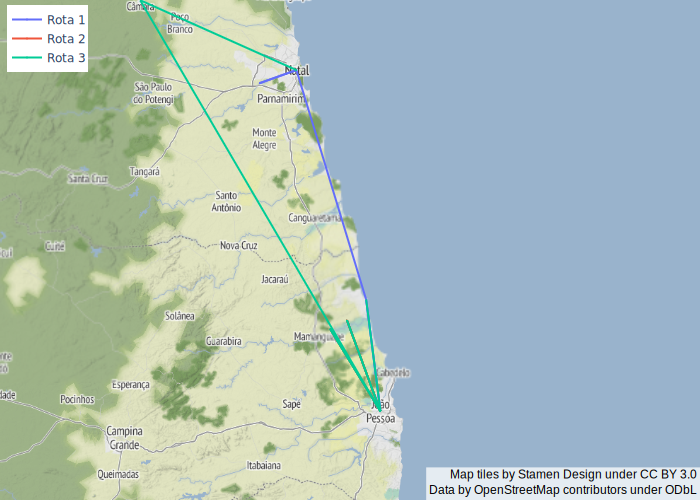

In [149]:
import plotly.graph_objects as go

fig = go.Figure(go.Scattermapbox(
    mode = "markers+lines",
    lon =  df_instance['lon'],
    lat = df_instance['lat'],
    hovertext = df_instance['county'],
    hoverinfo = 'text',
    visible=False,
    marker = {'size': 10}))

for index, route in enumerate(real_routes):
    
    lons = [df_instance['lon'].iloc[node] for node in route]
    lats = [df_instance['lat'].iloc[node] for node in route]
    
    fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = lons,
    lat = lats,
    # hovertext = df_instance['county'],
    hoverinfo = 'text',
    name = 'Rota ' + str(index + 1),
    marker = {'size': 2}))
        
fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'style': "stamen-terrain",
        'center': {'lon': -35, 'lat': -6.5},
        'zoom': 7.5})

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show("svg")

In [150]:
deliveries_indexes = df_instance[df_instance['type'].isin(['Pickup','Delivery'])].index

met_demands = dict(zip(list(deliveries_indexes), [0 for i in deliveries_indexes]))

for k in model.setK:
    
    for v in model.setV:

        for i in model.setN:

            for j in (model.setP | model.setD):

                if ((pyo.value(model.x[i,j,k,v]))>0.01):
                    
                    met_demands[j] += pyo.value(model.z[j,k,v])

                    
for index in df_instance[df_instance['type'] == 'Depot'].index:
    
    met_demands[index] = 0
    

met_demand_data = [value for value in dict(sorted(met_demands.items())).values()]

df_instance['met_demand'] = met_demand_data
                    
df_instance['relative_met_demand'] = [round(abs(met_demand/demand),2) if demand != 0 else 0 for met_demand, demand in zip(df_instance['met_demand'],df_instance['d'])]

In [151]:
df_instance

,type,county,lat,lon,s,d,w_a,w_b,met_demand,relative_met_demand
0,Depot,JOÃO PESSOA,-7.121598,-34.882028,0.0,0.0,0.0,50.0,0.0,0.00
1,Depot,NATAL,-5.805398,-35.20809,0.0,0.0,0.0,50.0,0.0,0.00
2,Pickup,JOÃO PESSOA,-7.121598,-34.882028,0.2,6899.0,0.0,50.0,6000.0,0.87
3,Pickup,NATAL,-5.805398,-35.20809,0.2,2226.0,0.0,50.0,1800.0,0.81
4,Delivery,BAIA DA TRAIÇÃO,-6.691258,-34.937124,0.35,-2444.0,0.0,50.0,2350.0,0.96
5,Delivery,JOÃO PESSOA,-7.121598,-34.882028,0.3,-128.0,0.0,50.0,0.0,0.00
6,Delivery,MARCAÇÃO,-6.770411,-35.012148,0.37,-2811.0,0.0,50.0,2800.0,1.00
7,Delivery,RIO TINTO,-6.803828,-35.077569,0.31,-1516.0,0.0,50.0,1400.0,0.92
8,Delivery,BAÍA FORMOSA,-6.369188,-35.006374,0.3,-332.0,0.0,50.0,0.0,0.00
9,Delivery,CANGUARETAMA,-6.375194,-35.137463,0.2,-282.0,0.0,50.0,0.0,0.00
